## Imports

In [606]:
import numpy as np
from sklearn.linear_model import LinearRegression

from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

## Higher Order functions

In [607]:
# series of functions performing exponentiation to given power
def square(x):
    return x**2

def cube(x):
    return x**3

# make exponent and explicit argument
def generic_exp(x,exponent): # requires specify the exponent everytime you call the function
    return x**exponent



We need higher order function(function builder) to build functions (square,cube ...)

In [608]:
def skeleton_exponentiation(x):
    return x**exponent

In [609]:
# skeleton_exponentiation(2)

<span style="color:red">---------------------------------------------------------------------------</span>  
<span style="color:red">NameError</span>                                 Traceback (most recent call last)  
Cell In[9], line 1  
<span style="color:green">----> 1 skeleton_exponentiation(2)</span>  
  
Cell In[8], line 2  
      1 def skeleton_exponentiation(x):  
<span style="color:green">----> 2     return x**exponent</span>  
  
<span style="color:red">NameError</span>: name 'exponent' is not defined  

In [610]:
def exponentiation_builder(exponent):
    def skeleton_exponentiation(x):
        return x**exponent

    return skeleton_exponentiation

In [611]:
returned_function=exponentiation_builder(2)
returned_function

<function __main__.exponentiation_builder.<locals>.skeleton_exponentiation(x)>

In [612]:
exponentiation_builder(2)(4)

16

In [613]:
returned_function(5)

25

In [614]:
cube=exponentiation_builder(3)
cube(5)

125

In [615]:
# Helper functiom 1
def make_train_step(model,loss_fn,optimizer): 
    # Build a function that perform a step in the train loop
    def perform_train_step_fn(x,y):

        # set model to train state
        model.train()

        # forward pass
        y_hat=model(x)

        # compute loss
        loss=loss_fn(y_hat,y)

        # compute gradients
        loss.backward()

        # update parameters
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()

    # return the function that will be called inside the train loop
    return perform_train_step_fn 

Run: Data preperation 

In [616]:
%run -i data_generation/simple_linear_regression.py

In [617]:
%run -i data_preparation/v0.py

In [618]:
%%writefile model_configuration/v1.py

device='cuda' if torch.cuda.is_available() else 'cpu'
lr=0.1

torch.manual_seed(42)
# create a model and send it to device
model=nn.Sequential(nn.Linear(1,1)).to(device)

# define SGD optmizer
optimizer=optim.SGD(model.parameters(),lr=lr)

# define loss function
loss_fn=nn.MSELoss(reduction='mean')

# create train step function
train_step_fn=make_train_step(model,loss_fn,optimizer)


Overwriting model_configuration/v1.py


In [619]:
%run -i model_configuration/v1.py

In [620]:
train_step_fn

<function __main__.make_train_step.<locals>.perform_train_step_fn(x, y)>

In [621]:
%%writefile model_training/v1.py

n_epochs=1000
losses=[]

for epoch in tqdm(range(n_epochs)):

    # perform train step and return corresponding loss
    loss=train_step_fn(X_train_tensor,y_train_tensor) # perform one training step
    losses.append(loss) # keep track of loss

Overwriting model_training/v1.py


In [622]:
%run -i model_training/v1.py

  0%|          | 0/1000 [00:00<?, ?it/s]

In [623]:
model.state_dict()

OrderedDict([('0.weight', tensor([[1.9690]])), ('0.bias', tensor([1.0235]))])

## Dataset

In [624]:
class CustomDataset(Dataset):
    # takes whatever arguments that need to create a list of tuples
    def __init__(self,x_tensor,y_tensor):
        self.x=x_tensor
        self.y=y_tensor

    # return a tuple corresponding to the index, load data on demand
    def __getitem__(self,index):
        return (self.x[index],self.y[index])

    # return the size of the dataset
    def __len__(self):
        return len(self.x)

X_train_tensor=torch.as_tensor(X_train).float() # we don't want to store whole training data into GPU tensors, it will eat up vram
y_train_tensor=torch.as_tensor(y_train).float()

train_data=CustomDataset(X_train_tensor,y_train_tensor)
print(train_data[[1,2,4]])

(tensor([[0.0636],
        [0.8631],
        [0.7320]]), tensor([[1.1928],
        [2.9128],
        [2.4732]]))


## Tensor Dataset

In [625]:
train_data=TensorDataset(X_train_tensor,y_train_tensor) # if dataset is couple of tensors, use TensorDataset
print(train_data[[1,2,4]])

(tensor([[0.0636],
        [0.8631],
        [0.7320]]), tensor([[1.1928],
        [2.9128],
        [2.4732]]))


## Dataloader

In [626]:
# Dataloader is an iterator that will load data on demand
train_loader=DataLoader(dataset=train_data,batch_size=16,shuffle=True)
train_loader

In [627]:
next(iter(train_loader)) # this will load the first batch of data

[tensor([[0.2809],
         [0.3253],
         [0.1560],
         [0.5924],
         [0.0651],
         [0.8872],
         [0.4938],
         [0.0055],
         [0.1409],
         [0.0885],
         [0.1849],
         [0.7290],
         [0.8662],
         [0.3117],
         [0.6842],
         [0.1987]]),
 tensor([[1.5846],
         [1.8057],
         [1.2901],
         [2.1687],
         [1.1559],
         [2.8708],
         [1.9060],
         [1.0632],
         [1.1211],
         [1.0708],
         [1.5888],
         [2.4927],
         [2.6805],
         [1.7637],
         [2.3492],
         [1.2654]])]

In [628]:
list(train_loader) # this will load all the data

[[tensor([[0.7852],
          [0.8022],
          [0.6075],
          [0.1997],
          [0.3309],
          [0.6376],
          [0.4722],
          [0.2809],
          [0.4938],
          [0.5427],
          [0.1560],
          [0.1987],
          [0.3745],
          [0.0885],
          [0.7320],
          [0.8872]]),
  tensor([[2.5283],
          [2.6229],
          [2.4037],
          [1.3651],
          [1.5427],
          [2.1930],
          [1.9857],
          [1.5846],
          [1.9060],
          [2.2161],
          [1.2901],
          [1.2654],
          [1.7578],
          [1.0708],
          [2.4732],
          [2.8708]])],
 [tensor([[0.6842],
          [0.0452],
          [0.1159],
          [0.0055],
          [0.3664],
          [0.7751],
          [0.7608],
          [0.7132],
          [0.8631],
          [0.6011],
          [0.1705],
          [0.0344],
          [0.9869],
          [0.0651],
          [0.2921],
          [0.9696]]),
  tensor([[2.3492],
          [0.

We need to add Dataloader and Dataset elements into Data prep file

In [629]:
%%writefile data_preparation/v1.py

X_train_tensor=torch.as_tensor(X_train).float()
y_train_tensor=torch.as_tensor(y_train).float()

# Builds Dataset
train_data=TensorDataset(X_train_tensor,y_train_tensor)

# Build Dataloader
train_loader=DataLoader(dataset=train_data,batch_size=16,shuffle=True)


Overwriting data_preparation/v1.py


In [630]:
%run -i data_preparation/v1.py

Now we need to introduce mini batch gradient descent to model training part

In [631]:
%run -i model_configuration/v1.py

In [632]:
%%writefile model_training/v2.py

# Define number of epochs
n_epochs=1000

losses=[]

for epoch in tqdm(range(n_epochs)):
    # inner loop
    mini_batch_losses=[]
    for x_batch,y_batch in train_loader:
        # the dataset lives on CPU, we need to send mini-batches to the device where our model lives
        x_batch=x_batch.to(device)
        y_batch=y_batch.to(device)
        
        # perform training step and return corresponding loss
        mini_batch_loss=train_step_fn(x_batch,y_batch)
        mini_batch_losses.append(mini_batch_loss)

    # compute average loss over all mini batches
    loss=np.mean(mini_batch_losses)
    losses.append(loss)


Overwriting model_training/v2.py


In [633]:
%run -i model_training/v2.py

  0%|          | 0/1000 [00:00<?, ?it/s]

In [634]:
model.state_dict()

OrderedDict([('0.weight', tensor([[1.9696]])), ('0.bias', tensor([1.0243]))])

Full pipeline

In [635]:
%run -i data_preparation/v1.py
%run -i model_configuration/v1.py
%run -i model_training/v2.py

  0%|          | 0/1000 [00:00<?, ?it/s]

## Mini Batch inner loop  
Mini batch depends on 3 elements.
1. device
2. dataloader
3. step function

In [636]:
# Helper function 2
def mini_batch(device,dataloader,step_fn):
    mini_batch_losses=[]
    for x_batch,y_batch in dataloader:
        x_batch=x_batch.to(device)
        y_batch=y_batch.to(device)

        mini_batch_loss=step_fn(x_batch,y_batch)
        mini_batch_losses.append(mini_batch_loss)

    loss=np.mean(mini_batch_losses)
    return loss

Now we only need 200 epoch to perform 1000 updates due to mini batch inner loop



In [637]:
%run -i data_preparation/v1.py
%run -i model_configuration/v1.py

Define model training v3

In [638]:
%%writefile model_training/v3.py

# Define number of epochs
n_epochs=200

losses=[]

for epoch in tqdm(range(n_epochs)):
    loss=mini_batch(device,train_loader,train_step_fn)
    losses.append(loss)


Overwriting model_training/v3.py


In [639]:
%run -i model_training/v3.py

  0%|          | 0/200 [00:00<?, ?it/s]

In [640]:
model.state_dict()

OrderedDict([('0.weight', tensor([[1.9684]])), ('0.bias', tensor([1.0219]))])

## Random Split

In [641]:
%%writefile data_preparation/v2.py

torch.manual_seed(13)

# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

# Builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Performs the split
ratio = .8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train

train_data, val_data = random_split(dataset, [n_train, n_val])

# Builds a loader of each set
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16)

Overwriting data_preparation/v2.py


In [642]:
%run -i data_preparation/v2.py

* Dropout is the reason for setting the mode train() or eval()  
* Dropout randomly set some weights to zero while training, this will be a problem for evaluation. So we use model.eval()


In [643]:
# Helper function 3
def make_val_step(model,loss_fn):

    # Build a function that perform a step in the validation loop
    def perform_val_step_fn(X,y):
        #set model to eval mode
        model.eval()

        # forward pass
        y_hat=model(X)

        # compute the loss
        loss=loss_fn(y_hat,y) 
        
        return loss.item() # loss.item() will return the value of the loss as python number
    return perform_val_step_fn


model, optimizer, loss fn, train step fn ,val step fn

In [644]:
%%writefile model_configuration/v2.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a SGD optimizer to update the parameters (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Creates the train_step function for our model, loss function and optimizer
train_step_fn = make_train_step(model, loss_fn, optimizer)

# Creates the val_step function for our model and loss function
val_step_fn = make_val_step(model, loss_fn)


Overwriting model_configuration/v2.py


In [645]:
%run -i model_configuration/v2.py

In [646]:
%%writefile model_training/v4.py

# Defines number of epochs
n_epochs = 200

losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    # inner loop
    loss = mini_batch(device, train_loader, train_step_fn)
    losses.append(loss)
    
    # VALIDATION
    # no gradients in validation!
    with torch.no_grad():
        val_loss = mini_batch(device, val_loader, val_step_fn)
        val_losses.append(val_loss)  

Overwriting model_training/v4.py


In [647]:
%run -i model_training/v4.py

  0%|          | 0/200 [00:00<?, ?it/s]

In [648]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9438]])), ('0.bias', tensor([1.0287]))])


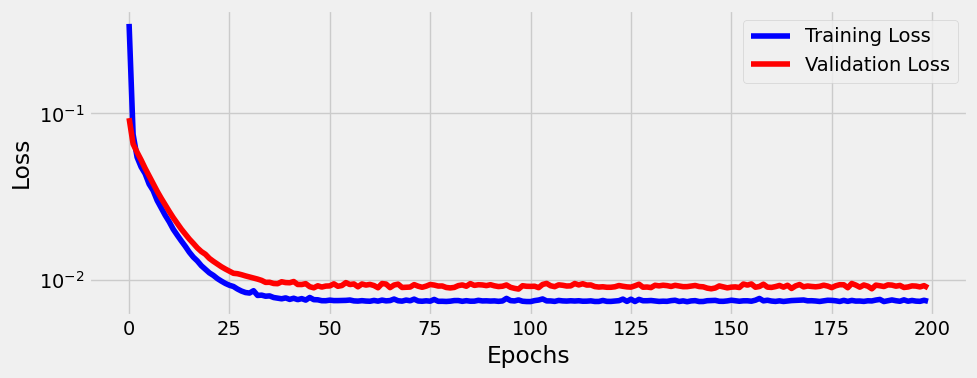

In [652]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

def plot_losses(losses, val_losses):
    fig = plt.figure(figsize=(10, 4))
    plt.plot(losses, label='Training Loss', c='b')
    plt.plot(val_losses, label='Validation Loss', c='r')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    return fig

fig=plot_losses(losses,val_losses)

## Tensor Board

Load the tensorboard notebook extenstion

In [653]:
%load_ext tensorboard

Running Tensorboard

In [660]:
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 11328), started 0:31:41 ago. (Use '!kill 11328' to kill it.)

SummaryWriter

In [661]:
writer=SummaryWriter('runs/test')

The summary writer implement several methods to allow us to send info to tensorboard  
  
* add_graph()
* add_scalars()
* add_scalar()
* add_histogram()
* add_images()
* add_image()
* add_figure()
* add_video()
* add_audio()
* add_text()
* add_embedding()
* add_pr_curve()
* add_custom_scalars()
* add_mesh
* add_hparams()

It also implement other methods that write data to disk  

* flush()
* close()


## Add graph

In [663]:
dummy_x,dummy_y=next(iter(train_loader))

# both model and data live on the same device
writer.add_graph(model,dummy_x.to(device))

## Add scalars

Adding losses

In [666]:
writer.add_scalar(main_tag='loss',
                  tag_scalar_dict={'training':loss,'validation':val_loss}
                  ,global_step=epoch)

TypeError: SummaryWriter.add_scalar() got an unexpected keyword argument 'main_tag'

In [668]:
%run -i data_preparation/v2.py

Define Model config v3

In [671]:
%%writefile model_configuration/v3.py

device='cuda' if torch.cuda.is_available() else 'cpu'

# set learning rate
lr=0.1

torch.manual_seed(42)
# create a model and send it to device
model=nn.Sequential(nn.Linear(1,1)).to(device)

# define SGD optimizer to update parameters
optimizer=optim.SGD(model.parameters(),lr=lr)

# define mse loss function
loss_fn=nn.MSELoss(reduction='mean')

# craete train step function for our model, loss function and optimizer
train_step_fn=make_train_step(model,loss_fn,optimizer)

# create val step function for model and loss function
val_step_fn=make_val_step(model,loss_fn)

# Create summary writer to interface with tensorboard.
writer=SummaryWriter('runs/simple_linear_regression')
# fetch a single mini batch so we can use add_graph()
X_dummy,y_dummy=next(iter(train_loader))
writer.add_graph(model,X_dummy.to(device)) 

Overwriting model_configuration/v3.py


In [672]:
%run -i model_configuration/v3.py

define Model Training v5

In [673]:
%%writefile model_training/v5.py
# Define number of epochs
n_epochs=200

losses=[]
val_losses=[]

for epoch in tqdm(range(n_epochs)):
    #inner loop
    loss=mini_batch(device,train_loader,train_step_fn)
    losses.append(loss)

    # Validation: No gradients in validation
    with torch.no_grad():
        val_loss=mini_batch(device,val_loader,val_step_fn)
        val_losses.append(val_loss)
    
    # Record both losses for each epoch under tag 'loss'
    writer.add_scalars(main_tag='loss',
                       tag_scalar_dict={'training':loss,'validation':val_loss},
                       global_step=epoch) # global step is used to keep track of x-axis

# Close the writer
writer.close()

Writing model_training/v5.py


In [674]:
%run -i model_training/v5.py

  0%|          | 0/200 [00:00<?, ?it/s]

In [675]:
# check models state
model.state_dict()

OrderedDict([('0.weight', tensor([[1.9432]])), ('0.bias', tensor([1.0263]))])

## Saving and Loading Models

Saving checkpoint

In [679]:
checkpoint={'epoch':n_epochs,
            'model_state_dict':model.state_dict(),
            'optimizer_state_dict':optimizer.state_dict(),
            'loss':losses,
            'val_loss':val_losses}

torch.save(checkpoint,'model_checkpoint.pth') # checkpoint conmtains all the information we need to resume training or to use the fully trained model for inference

Resume Training: first we need to load the data and configure the model

In [680]:
%run -i data_preparation/v2.py
%run -i model_configuration/v3.py

In [681]:
model.state_dict() # parameters of untrained model

OrderedDict([('0.weight', tensor([[0.7645]])), ('0.bias', tensor([0.8300]))])

In [682]:
# Loading checkpont and resume training
checkpoint=torch.load('model_checkpoint.pth')

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

saved_epoch=checkpoint['epoch']
saved_losses=checkpoint['loss']
saved_val_losses=checkpoint['val_loss']

model.train() # Always set the model to train state after loading the checkpoint

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)

In [683]:
model.state_dict()

OrderedDict([('0.weight', tensor([[1.9432]])), ('0.bias', tensor([1.0263]))])

In [684]:
%run -i model_training/v5.py

  0%|          | 0/200 [00:00<?, ?it/s]

In [685]:
model.state_dict()

OrderedDict([('0.weight', tensor([[1.9432]])), ('0.bias', tensor([1.0263]))])

In [686]:
def plot_resumed_losses(saved_epoch, saved_losses, saved_val_losses, n_epochs, losses, val_losses):
    range_before = range(0, saved_epoch)
    range_after = range(saved_epoch, saved_epoch + n_epochs)

    fig = plt.figure(figsize=(10, 4))
    # Checkpointed loss
    plt.plot(range_before, saved_losses, 
             label='Checkpointed Training Loss', c='b', linestyle='--')
    plt.plot(range_before, saved_val_losses, 
             label='Checkpointed Validation Loss', c='r', linestyle='--')
    # Losses after resuming
    plt.plot(range_after, losses, label='Training Loss', c='b')
    plt.plot(range_after, val_losses, label='Validation Loss', c='r')
    # Divider
    plt.plot([saved_epoch, saved_epoch],
             [np.min(saved_losses + losses), np.max(saved_losses + losses)], 
             c='k', linewidth=1, linestyle='--', label='Checkpoint')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    return fig

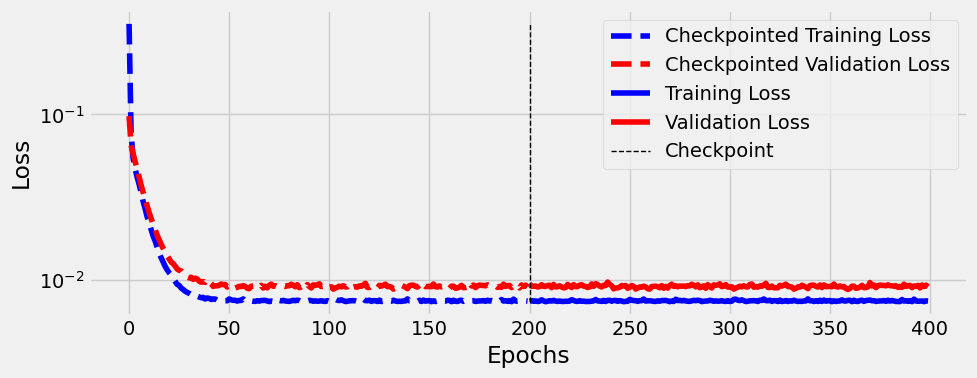

In [687]:
fig = plot_resumed_losses(saved_epoch, saved_losses, saved_val_losses, n_epochs, losses, val_losses)

## Deploying/Making Predictions

We have to set the stage before loading the model

In [689]:
%run -i model_configuration/v3.py

In [690]:
# since model is fully trained, we only need model state dict
checkpoint=torch.load('model_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9432]])), ('0.bias', tensor([1.0263]))])


After recovering the fully trained models state, we can use it for predictions

In [691]:
new_inputs=torch.tensor([[0.20],[0.34],[0.57]])

model.eval() # Always use model in eval mode for inference
model(new_inputs.to(device))

tensor([[1.4150],
        [1.6870],
        [2.1340]], grad_fn=<AddmmBackward0>)